# LiDAR-Net

## Create network

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, AveragePooling2D, Conv2DTranspose
from tensorflow.keras.layers import BatchNormalization, LeakyReLU, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
import os
import pcl
import math

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [3]:
class ResContextBlock(tf.keras.Model):
    def __init__(self, out_filters):
        super(ResContextBlock, self).__init__()
        self.conv1 = Conv2D(out_filters, kernel_size=(1, 1), strides=1)
        self.act1 = LeakyReLU()

        self.conv2 = Conv2D(out_filters, kernel_size=(3,3), padding='same')
        self.act2 = LeakyReLU()
        self.bn1 = BatchNormalization()

        self.conv3 = Conv2D(out_filters, kernel_size=(3,3), dilation_rate=2, padding='same')
        self.act3 = LeakyReLU()
        self.bn2 = BatchNormalization()


    def call(self, x):

        shortcut = self.conv1(x)
        shortcut = self.act1(shortcut)

        resA = self.conv2(shortcut)
        resA = self.act2(resA)
        resA1 = self.bn1(resA)

        resA = self.conv3(resA1)
        resA = self.act3(resA)
        resA2 = self.bn2(resA)

        output = shortcut + resA2
        return output

In [4]:
class ResBlock(tf.keras.Model):
    def __init__(self, out_filters, dropout_rate, kernel_size=(3, 3), stride=1,
                 pooling=True, drop_out=True):
        super(ResBlock, self).__init__()
        self.pooling = pooling
        self.drop_out = drop_out
        self.conv1 = Conv2D(out_filters, kernel_size=(1, 1), strides=stride)
        self.act1 = LeakyReLU()

        self.conv2 = Conv2D(out_filters, kernel_size=(3, 3), padding='same')
        self.act2 = LeakyReLU()
        self.bn1 = BatchNormalization()

        self.conv3 = Conv2D(out_filters, kernel_size=(3,3),dilation_rate=2, padding='same')
        self.act3 = LeakyReLU()
        self.bn2 = BatchNormalization()

        self.conv4 = Conv2D(out_filters, kernel_size=(2, 2), dilation_rate=2, padding='same')
        self.act4 = LeakyReLU()
        self.bn3 = BatchNormalization()

        self.conv5 = Conv2D(out_filters, kernel_size=(1, 1))
        self.act5 = LeakyReLU()
        self.bn4 = BatchNormalization()

        if pooling:
            self.dropout = Dropout(dropout_rate)
            self.pool = AveragePooling2D(pool_size=kernel_size, strides=2, padding='same')
        else:
            self.dropout = Dropout(dropout_rate)

    def call(self, x):
        shortcut = self.conv1(x)
        shortcut = self.act1(shortcut)

        resA = self.conv2(x)
        resA = self.act2(resA)
        resA1 = self.bn1(resA)

        resA = self.conv3(resA1)
        resA = self.act3(resA)
        resA2 = self.bn2(resA)

        resA = self.conv4(resA2)
        resA = self.act4(resA)
        resA3 = self.bn3(resA)

        concat = tf.concat((resA1,resA2,resA3),axis=-1)
        resA = self.conv5(concat)
        resA = self.act5(resA)
        resA = self.bn4(resA)
        resA = shortcut + resA


        if self.pooling:
            if self.drop_out:
                resB = self.dropout(resA)
            else:
                resB = resA
            resB = self.pool(resB)
            return resB, resA
        else:
            if self.drop_out:
                resB = self.dropout(resA)
            else:
                resB = resA
            return resB

In [5]:
class UpBlock(tf.keras.Model):
    def __init__(self, out_filters, dropout_rate, drop_out=True):
        super(UpBlock, self).__init__()
        self.drop_out = drop_out
        self.out_filters = out_filters

        self.dropout1 = Dropout(dropout_rate)
        self.dropout2 = Dropout(dropout_rate)

        self.conv1 = Conv2D(out_filters, kernel_size=(3,3), padding='same')
        self.act1 = LeakyReLU()
        self.bn1 = BatchNormalization()

        self.conv2 = Conv2D(out_filters, kernel_size=(3,3),dilation_rate=2, padding='same')
        self.act2 = LeakyReLU()
        self.bn2 = BatchNormalization()

        self.conv3 = Conv2D(out_filters, kernel_size=(2,2), dilation_rate=2,padding='same')
        self.act3 = LeakyReLU()
        self.bn3 = BatchNormalization()


        self.conv4 = Conv2D(out_filters,kernel_size=(1,1))
        self.act4 = LeakyReLU()
        self.bn4 = BatchNormalization()
        self.dropout3 = Dropout(dropout_rate)

    def call(self, x, skip):
        upA = tf.nn.depth_to_space(x,2)
        if self.drop_out:
            upA = self.dropout1(upA)

        upB = tf.concat((upA,skip),axis=-1)
        if self.drop_out:
            upB = self.dropout2(upB)

        upE = self.conv1(upB)
        upE = self.act1(upE)
        upE1 = self.bn1(upE)

        upE = self.conv2(upE1)
        upE = self.act2(upE)
        upE2 = self.bn2(upE)

        upE = self.conv3(upE2)
        upE = self.act3(upE)
        upE3 = self.bn3(upE)

        concat = tf.concat((upE1,upE2,upE3),axis=-1)
        upE = self.conv4(concat)
        upE = self.act4(upE)
        upE = self.bn4(upE)
        if self.drop_out:
            upE = self.dropout3(upE)

        return upE

In [6]:
INPUT_SHAPE = [None,None,4]
# Input shape kitti dataset
#INPUT_SHAPE = [2048,64,5]
# input shape of bugalog data
#INPUT_SHAPE = [1024,16,4]
# min input shape
#INPUT_SHAPE = [16,16,5]

K.clear_session()

input_layer = Input(shape=INPUT_SHAPE)
x = ResContextBlock(32)(input_layer)
x = ResContextBlock(32)(x)
x = ResContextBlock(32)(x)
x,resBlock1 = ResBlock(64, 0.2, pooling=True, drop_out=False)(x)

# NOTE evetnuell resBlock1 tiefe verdoppeln um genauigkeit zu erhöhen
x,resBlock2 = ResBlock(128, 0.2, pooling=True)(x)
x,resBlock3 = ResBlock(128, 0.2, pooling=True)(x)
x,resBlock4 = ResBlock(256, 0.2, pooling=True)(x)

x = ResBlock(256, 0.2, pooling=False)(x)

x = UpBlock(128, 0.2)(x,resBlock4)
x = UpBlock(128, 0.2)(x,resBlock3)
x = UpBlock(64, 0.2)(x,resBlock2)
x = UpBlock(32, 0.2, drop_out=False)(x,resBlock1)

logits = Conv2D(3, kernel_size=(1, 1), activation="softmax")(x)

model = Model(inputs=input_layer, outputs=logits)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 4)]   0         
_________________________________________________________________
res_context_block (ResContex (None, None, None, 32)    18912     
_________________________________________________________________
res_context_block_1 (ResCont (None, None, None, 32)    19808     
_________________________________________________________________
res_context_block_2 (ResCont (None, None, None, 32)    19808     
_________________________________________________________________
res_block (ResBlock)         ((None, None, None, 64),  87360     
_________________________________________________________________
res_block_1 (ResBlock)       ((None, None, None, 128), 346752    
_________________________________________________________________
res_block_2 (ResBlock)       ((None, None, None, 128), 428672

In [7]:
#tf.keras.models.save_model(model, "test", save_format='h5')

## Prepare data

In [8]:
BatchSize = 4 # für 64er pc => BatchSize=4 #für 16er pc & 5,xMill. Param => 32 
Epochs = 10 # 15 für 80% accuracy
LearningRate = 1e-5

In [9]:
from laserscan import LaserScan, SemLaserScan
#from laserscanvis import LaserScanVis
import yaml

In [10]:
# Generate color map and lookup tables

# Load configuration file
CFG = yaml.safe_load(open('../config/semantic-kitti_GroundObject.yaml','r'))

# Read kitti classes to color dictionary from configuration
KittiToColorDict = CFG['color_map']

# Read kitti to master project classes dictionary from configuration
KittiToProjectDict = CFG['learning_map']

# Read master project to kitti dictionary from configuration
ProjectToKittiDict = CFG['learning_map_inv']

# Create lookup table for kitti classes to color
maxkeyColor = max(KittiToColorDict.keys()) + 100 # +100 hack making lut bigger in case there are unknown labels
KittiToColor_LUT = np.zeros((maxkeyColor, 3), dtype=np.uint8)
KittiToColor_LUT[list(KittiToColorDict.keys())] = list(KittiToColorDict.values())

# Create lookup table for kitti classes to master project classes
maxkey = max(KittiToProjectDict.keys()) + 100 # +100 hack making lut bigger in case there are unknown labels 
maxvalue = max(KittiToProjectDict.values())
KittiToProject_LUT = np.zeros((maxkey), dtype=np.int32)
KittiToProject_LUT[list(KittiToProjectDict.keys())] = list(KittiToProjectDict.values())

# Create lookup table for master project classes to kitti classes
maxkeyInv = max(ProjectToKittiDict.keys()) + 100 # +100 hack making lut bigger in case there are unknown labels
ProjectToKitti_LUT = np.zeros((maxkeyInv), dtype=np.int32)
ProjectToKitti_LUT[list(ProjectToKittiDict.keys())] = list(ProjectToKittiDict.values())

In [11]:
def getSampleArrayFromPointCloud (PointCloud, sample_path):
    # Load point cloud from bin
    PointCloud.open_scan(sample_path)
    
    xyz = PointCloud.proj_xyz.copy()
    # Get intensity and range from point cloud
    Intensity = PointCloud.proj_remission.copy()
    #Intensity = Intensity * 0.8
    #Intensity[Intensity < 0] = -1
    #Range = PointCloud.proj_range.copy()
    
    # Expand dimensions to enable concatenate
    Intensity = np.expand_dims(Intensity,axis=2)
    #Range = np.expand_dims(Range,axis=2)
    
    # Concatenate intensity and range
    xyzi = np.concatenate((xyz, Intensity),axis=2)
    xyzi = np.swapaxes(xyzi,0,1)
    return xyzi

In [34]:
def getSampleArrayFromPointCloud_pcd (PointCloud, sample_path):
    # Load point cloud from pcd
    cloud = pcl.load_XYZI(sample_path)
    cloud = cloud.to_array()
    # Get points and intensity (remission) from pcd point cloud
    points = cloud[:, 0:3]    # get xyz
    
    #points[:,2] = points[:,2] - 1.13
    #camera 1,90
    #kitty 1,73
    #camera zu top +0,53
    #top 2,43
    #top zu front -1,83
    #front 0,6
    #front zu kitti 1,13
    #top zu kitti -0,7
    
    remissions = cloud[:, 3]/255 #normal remissions
    
    # Set points and remission to PointCloud
    PointCloud.set_points(points, remissions)
    
    xyz = PointCloud.proj_xyz.copy()
    xyz[:,:,2] = xyz[:,:,2] -1.13 #+0.7 #- 1.13
    
    # Get intensity and range from point cloud
    Intensity = PointCloud.proj_remission.copy()
    #Range = PointCloud.proj_range.copy()

    #remissions max 100:
    #Intensity_orig = Intensity.copy()
    #print(Intensity.shape)
    #print(np.max(Intensity))
    #Intensity[Intensity > 100] = -1 # not reflective elements
    #Intensity[Intensity <= 100] = -1 # reflective elemtns
    #Intensity = Intensity/np.max(Intensity)
    #Intensity[Intensity < 0] = -1
    #print(np.max(Intensity))
    #print(np.min(Intensity))
    
    #Range[Intensity_orig > 100] = -1# not reflective
    #Range[Intensity_orig <= 100] = -1 # reflective
    
    # Expand dimensions to enable concatenate
    Intensity = np.expand_dims(Intensity,axis=2)
    #Range = np.expand_dims(Range,axis=2)
    
    # Concatenate intensity and range
    xyzi = np.concatenate((xyz, Intensity),axis=2)
    xyzi = np.swapaxes(xyzi,0,1)
    return xyzi

In [13]:
def getLabelArrayFromPointCloud(PointCloud, label_path):
    # Load point cloud from bin
    PointCloud.open_label(label_path)
    
    # Get labels from point cloud
    Labels = PointCloud.proj_sem_label.copy()
    
    # Map kitti classes to project classes
    Labels = KittiToProject_LUT[Labels]
    Labels = np.swapaxes(Labels,0,1)
    Labels = tf.keras.utils.to_categorical(Labels,num_classes=maxvalue+1)
    return Labels

In [14]:
def PointCloudGenerator(sample_paths, label_paths, batch_size, random=True): #add , pointcloud_size):
    """
    sample_paths = [sample_path1, sample_path2, ...]
    label_paths = [label_path1, label_path2, ...]
    """
    
    if random == True:
        sample_paths, label_paths = shuffle(sample_paths, label_paths, random_state=42)
        
    num_samples = len(sample_paths)

    while True: # Loop forever so the generator never terminates
        # Get index to start each batch: [0, batch_size, 2*batch_size, ..., max multiple of batch_size <= num_samples]
        for offset in range(0, num_samples, batch_size):
            # Get the samples + paths you'll use in this batch
            batch_sample_paths = sample_paths[offset:offset+batch_size]
            batch_label_paths = label_paths[offset:offset+batch_size]
            
            # Initialise X_train and y_train arrays for this batch
            X_train = []
            y_train = []

            # For each example
            for batch_sample,_ in enumerate(batch_sample_paths):
                
                # Load points (X) and labels (y)
                PointCloud = SemLaserScan(20, KittiToColorDict, project=True, W=2048, H=64)
                
                current_sample_path = batch_sample_paths[batch_sample]
                current_label_path = batch_label_paths[batch_sample]
                
                current_sample = getSampleArrayFromPointCloud (PointCloud, current_sample_path)
                current_sample = current_sample[0::2,0::4]
                
                current_label = getLabelArrayFromPointCloud(PointCloud, current_label_path)
                current_label = current_label[0::2,0::4]
                
                # Add example to arrays
                X_train.append(current_sample)
                y_train.append(current_label)

            # Make sure they're numpy arrays (as opposed to lists)
            X_train = np.array(X_train)
            y_train = np.array(y_train)

            # The generator-y part: yield the next training batch            
            yield X_train, y_train

In [15]:
# Define labeled data path
PATH = '/data/kitti_data/dataset/sequences/'
# Get all labeled sequences
sequences = [PATH + i for i in sorted(os.listdir(PATH))]

sample_paths = []
label_paths = []

# foreach labeled sequence -> get sample and lable path
for i in sequences:
    sample = i + '/velodyne/'
    label = i + '/labels/'
    for s in sorted(os.listdir(sample)):
        sample_paths.append(sample + s)
    for s in sorted(os.listdir(label)):
        label_paths.append(label + s)

In [16]:
# Shuffle paths and split them into training & validation paths
train_sample_paths, val_sample_paths, train_label_paths, val_label_paths = train_test_split(sample_paths, label_paths, train_size=0.8, random_state=42)
val_sample_paths, eval_sample_paths, val_label_paths, eval_label_paths = train_test_split(val_sample_paths, val_label_paths, train_size=0.75, random_state=42)

# Create training and validation generators
datagen = PointCloudGenerator(train_sample_paths, train_label_paths, BatchSize)
val_gen = PointCloudGenerator(val_sample_paths, val_label_paths, BatchSize)
eval_gen = PointCloudGenerator(eval_sample_paths, eval_label_paths, BatchSize)

## Train network

In [17]:
Optimizer = Adam(learning_rate = LearningRate)
# Configure model for training
model.compile(
loss='categorical_crossentropy',
optimizer=Optimizer,
metrics=['accuracy']
)

In [32]:
TrainingHistory = model.fit(
    x=datagen,
    epochs=Epochs,
    verbose=1,
    validation_data=val_gen,
    steps_per_epoch = math.ceil(len(train_sample_paths)/BatchSize),
    validation_steps = math.ceil(len(val_sample_paths)/BatchSize)
)

Train for 4640 steps, validate for 870 steps
Epoch 1/10
4640/4640 [==============================] - 1329s 286ms/step - loss: 0.3251 - accuracy: 0.8815 - val_loss: 0.2038 - val_accuracy: 0.9299
Epoch 2/10
4640/4640 [==============================] - 1326s 286ms/step - loss: 0.1922 - accuracy: 0.9345 - val_loss: 0.1740 - val_accuracy: 0.9407
Epoch 3/10
4640/4640 [==============================] - 1335s 288ms/step - loss: 0.1699 - accuracy: 0.9423 - val_loss: 0.1587 - val_accuracy: 0.9462
Epoch 4/10
4640/4640 [==============================] - 1336s 288ms/step - loss: 0.1573 - accuracy: 0.9466 - val_loss: 0.1481 - val_accuracy: 0.9499
Epoch 5/10
4640/4640 [==============================] - 1338s 288ms/step - loss: 0.1487 - accuracy: 0.9495 - val_loss: 0.1411 - val_accuracy: 0.9523
Epoch 6/10
4640/4640 [==============================] - 1352s 291ms/step - loss: 0.1421 - accuracy: 0.9517 - val_loss: 0.1355 - val_accuracy: 0.9541
Epoch 7/10
4640/4640 [==============================] - 1346s

In [33]:
#model.save_weights('../weights/model_weights_IR_16_1024.h5')
#model.save_weights('../weights/model_weights_IR_64_2048.h5')
model.save_weights('../weights/model_weights_xyzi_16_1024_GroundDetection_inklTerain.h5')

In [ ]:
#save model
#model.save("../NewGroundDetectionXYZI")
#model.to_json()

## Evaluate network general

In [ ]:
#model.load_weights('../weights/model_weights_xyzi_16_1024.h5')
#model.load_weights('../weights/model_weights_IR_64_2048.h5')
Evaluation = model.evaluate(eval_gen, steps=math.ceil(len(eval_sample_paths)/BatchSize))
print(Evaluation)

## Evaluate network visual

In [37]:
# Load reduced model weights
model.load_weights('../weights/model_weights_xyzi_16_1024_GroundDetection_inklTerain.h5')

# Load full model weights
#model.load_weights('../weights/model_weights_IR_64_2048.h5')



In [63]:
def PredictionToImage(Prediction):
    # Map masterproject classes to kitti classes 
    Prediction = ProjectToKitti_LUT[Prediction]
    # Map kitti classes to colors
    Image = KittiToColor_LUT[Prediction]
    Image = np.swapaxes(Image,0,1)
    Image = Image[...,[2,1,0]]
    return Image

(2048, 64, 4)


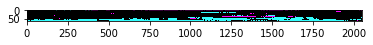

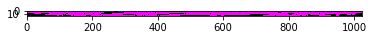

In [64]:
import matplotlib.pyplot as plt
%matplotlib inline

# Define path of test PoinCloud
TestPath = '/data/kitti_data/dataset/sequences'
CurrentTestPoinCloudPath = TestPath + '/04/velodyne/000008.bin'

# Create test PointCloud
TestPointCloud = SemLaserScan(20, KittiToColorDict, project=True, W=2048, H=64)

# Create full sample array from PoinCloud
CurrentTestSampleFull = getSampleArrayFromPointCloud (TestPointCloud, CurrentTestPoinCloudPath)
print(CurrentTestSampleFull.shape)
#print(np.min(CurrentTestSampleFull[:,:,2]))
CurrentTestSampleFull = np.expand_dims(CurrentTestSampleFull, axis=0)

# Create reduced sample array from full sample array
#print(CurrentTestSampleFull.shape)
CurrentTestSampleReduced = CurrentTestSampleFull[0::,0::2,0::4]
#print(np.min(CurrentTestSampleReduced[0,:,:,2]))
#print(CurrentTestSampleReduced.shape)

# Predict full PointCloud
PredictionFull = model.predict(CurrentTestSampleFull)
PredictionFull = np.argmax(PredictionFull,axis=3)
PredictionFull = PredictionFull.squeeze()

# Predict reduced PointCloud
PredictionReduced = model.predict(CurrentTestSampleReduced)
PredictionReduced = np.argmax(PredictionReduced,axis=3)
PredictionReduced = PredictionReduced.squeeze()

# Create images of predictions
PredictionFullImage = PredictionToImage(PredictionFull)
PredictionReducedImage = PredictionToImage(PredictionReduced)

# [optional] Spot special classes in image
#ids = np.where((CurrentTestSampleReduced[0,:,:,2] < -5))
#print(ids)
#PredictionReducedImage[ids] = [255, 0, 0]
#PredictionReducedImage = np.swapaxes(PredictionReducedImage,0,1)
#PredictionFullImage = np.swapaxes(PredictionFullImage,0,1)

# Show and save full prediction image
fig = plt.figure()
plt.imshow(PredictionFullImage)
plt.show
plt.imsave('../images/PredictionFull.png', PredictionFullImage)

# Show and save reduced prediction image
fig = plt.figure()
plt.imshow(PredictionReducedImage)
plt.show
plt.imsave('../images/PredictionReduced.png', PredictionReducedImage)

In [ ]:
CurrentTestLabelPath = TestPath + '/04/labels/000008.label'

CurrentLabelFull = getLabelArrayFromPointCloud (TestPointCloud, CurrentTestLabelPath)
CurrentLabelFull = np.expand_dims(CurrentLabelFull, axis=0)

CurrentLabelReduced = CurrentLabelFull[0::,0::2,0::4]

CurrentLabelFull = np.argmax(CurrentLabelFull,axis=3)
CurrentLabelFull = CurrentLabelFull.squeeze()

CurrentLabelReduced = np.argmax(CurrentLabelReduced,axis=3)
CurrentLabelReduced = CurrentLabelReduced.squeeze()

GroundTruthFullImage = PredictionToImage(CurrentLabelFull)
GroundTruthReducedImage = PredictionToImage(CurrentLabelReduced)

fig = plt.figure()
plt.imshow(GroundTruthFullImage)
plt.show
plt.imsave('../images/GroundTruthFullImage.png', GroundTruthFullImage)

fig = plt.figure()
plt.imshow(GroundTruthReducedImage)
plt.show
plt.imsave('../images/GroundTruthReducedImage.png', GroundTruthReducedImage)

In [ ]:
# Create intensity histogram of full kitti data
fig = plt.figure()
print(CurrentTestSampleFull.shape)
I = CurrentTestSampleFull[:,:,:,0].flatten()
# print(I.shape)
hist = plt.hist(I, bins='auto')
plt.title("Intensity histogram of full kitti data")
plt.show()

# Create intensity histogram of reduced kitti data
fig = plt.figure()
I = CurrentTestSampleReduced[:,:,:,0].flatten()
print(I.shape)
hist = plt.hist(I, bins='auto')  # arguments are passed to np.histogram
plt.title("Intensity histogram of reduced kitti data")
plt.show()

# Create range histogram of full kitti data
fig = plt.figure()
print(CurrentTestSampleFull.shape)
I = CurrentTestSampleFull[:,:,:,1].flatten()
# print(I.shape)
hist = plt.hist(I, bins='auto')
plt.title("Range histogram of full kitti data")
plt.show()

# Create range histogram of reduced kitti data
fig = plt.figure()
I = CurrentTestSampleReduced[:,:,:,1].flatten()
print(I.shape)
hist = plt.hist(I, bins='auto')  # arguments are passed to np.histogram
plt.title("Range histogram of reduced kitti data")
plt.show()

## Predict BugaLog data

17.704252
-2.743859


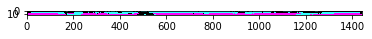

In [52]:
PCDPATH = '../data/pcd_files/'
current_pcd_path = PCDPATH + 'front_cloud_straße.pcd' #'top_cloud_git.pcd'

PointCloud = SemLaserScan(20, KittiToColorDict, project=True, W=1440, H=16, fov_up=15, fov_down=-15.0)

current_sample = getSampleArrayFromPointCloud_pcd(PointCloud, current_pcd_path)
#print(current_sample.shape)
#current_sample[:,:,2] = current_sample[:,:,2] -0.4#1.13 #+0.7 #- 1.13
print(np.max(current_sample[:,:,2]))
print(np.min(current_sample[:,:,2]))

#current_sample = current_pcd
current_sample = np.expand_dims(current_sample, axis=0)

#current_sample = current_sample[0::,0::2,0::4]
#current_sample[np.where(current_sample[:,:,:,0] > 0.4)] = [-1, -1]

Prediction = model.predict(current_sample)

Prediction = np.argmax(Prediction,axis=3)

Prediction = Prediction.squeeze()

BugaLogImage = PredictionToImage(Prediction)

plt.imshow(BugaLogImage)
plt.show
plt.imsave('../images/BugaLogImage.png', BugaLogImage)

In [ ]:
fig = plt.figure()
I = current_sample[:,:,:,0].flatten()
print(I.shape)
hist = plt.hist(I, bins='auto')  # arguments are passed to np.histogram
plt.title("Intensity histogram of buga log data")
plt.show()

fig = plt.figure()
R = current_sample[:,:,:,1].flatten()
print(R.shape)
hist = plt.hist(R, bins='auto')  # arguments are passed to np.histogram
plt.title("Range histogram of buga log data")
plt.show()

# Create result point cloud (unfinished)

In [46]:
#### import pcl
intensity = Prediction

input_cloud = current_sample.squeeze()

print(input_cloud.shape)
cloud = input_cloud.copy()
cloud[:,:,3]=Prediction
#cloud=cloud[:,:,0:4]
# überprüfen ob 0:4 oder 1:5
print(cloud.shape)

#print(input_cloud[1,1,:])
#print(cloud[1,1,:])


cloud = np.reshape(cloud, (cloud.shape[0]*cloud.shape[1], 4))

print(cloud.shape)

cloud = cloud[cloud[:,1]!= -1]

print(cloud.shape)

p = pcl.PointCloud_PointXYZI(cloud)

pcl.save(p, './newfrontcloud_straße.pcd')

(1440, 16, 4)
(1440, 16, 4)
(23040, 4)
(14446, 4)


In [ ]:
import pptk
import pandas as pd
import numpy as np
import pcl

In [ ]:
Cloud = pcl.load_XYZI('./newcloud.pcd')

In [ ]:
points = Cloud.to_array()
XYZ = points[:100:,0:3]
XYZ = pptk.rand(100,3)

print(XYZ.shape)
v = pptk.viewer(XYZ)
#v.attributes(points[:,3])
#v.set(point_size=0.005)